In [1]:
import numpy as np
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, fetch_covtype, load_digits
from enum import Enum
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
def mosthighlycorrelated(mydataframe, numtoreport):
    cormatrix = mydataframe.corr()
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    cormatrix.columns = ["FirstVariable", "SecondVariable", "Correlation"]
    print("Наилучшая корреляция:")
    print(cormatrix.head(numtoreport))
    print("Наихудшая корреляция:")
    print(cormatrix.tail(numtoreport))

In [3]:
def load_dataset(file_path):
  data = pd.read_csv(file_path, sep=',')
  data = np.array(data)
  X = data[:,1:-1]
  y = data[:,-1].astype(int)
  return (X, y)

In [4]:
class Rule(Enum):
  Kaiser = 1
  BSM = 2
  Scree = 3
  No = 4

In [5]:
def kaiser(eig_values):
    return eig_values[eig_values > eig_values.mean()].size

In [6]:
def BSM(eig_values):
  tr = eig_values.sum()
  n_eig_values = eig_values/tr
  stick = np.random.sample(eig_values.shape[0])
  stick = np.sort(stick/stick.sum())[::-1]
  return n_eig_values[n_eig_values > stick].size

In [7]:
def scree(eig_values):
  r = range(eig_values.shape[0])
  plt.plot(r, eig_values)
  plt.scatter(r, eig_values)
  plt.show()
  print("Enter number of components:")
  result = int(input())
  return result

In [8]:
map_rule_by_type = {
    Rule.BSM : BSM,
    Rule.Kaiser : kaiser,
    Rule.Scree : scree
}

In [9]:
map_rule_by_type[Rule.BSM]

<function __main__.BSM>

In [10]:
class PCA(object):

  def __init__(self, rule = Rule.No):
    self.rule = rule

  def fit(self, X):
    mosthighlycorrelated(pd.DataFrame(X), 10)
    #covariation matrix of original components
    cov_matrix = np.cov(X.T)
    #cov_matrix visualisation
    sns.heatmap(cov_matrix, vmax=1., square=False).xaxis.tick_top()
    plt.show()
    # eigenvalues and eigenvectors calculation
    eig_val_cov, eig_vec_cov = np.linalg.eig(cov_matrix)
    #list of pairs (value, vector)
    eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]
    #sorting pairs by decreasing eigenvalues
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    #setting number of comp-s
    self.n_components = map_rule_by_type[self.rule](eig_val_cov) if self.rule != Rule.No else X.shape[1]
    #transformation matrix
    self.mat_w = np.array([ p[1] for p in eig_pairs])[:self.n_components]
  

  def report(self):
    print('Number of components {0} {1}'.format(self.n_components, self.rule))
    print(self.mat_w)

  def transform(self, X):
    X_center = X - X.mean(axis=0)
    #transfroming data
    return self.mat_w.dot(X_center.T).T

In [11]:
def test_pca(X ,y):
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.model_selection import train_test_split
  from sklearn.metrics import accuracy_score, roc_auc_score
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

  clf = DecisionTreeClassifier(random_state=42, max_depth=20)
  clf.fit(X_train, y_train)
  preds = clf.predict_proba(X_test)
  print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                  preds.argmax(axis=1))))

In [12]:
def apply_dataset(X,y, rule =Rule.No):
  pca_ = PCA(rule=rule)
  pca_.fit(X)
  pca_.report()
  my_pca_X = pca_.transform(X)
  test_pca(my_pca_X, y)

In [13]:
def for_all_rules(X, y):
  for rule in [Rule.No, Rule.Kaiser, Rule.BSM, Rule.Scree ]:
    apply_dataset(X, y, rule)

## BREAST CANSER - 30 variables, 2 classes

In [14]:
X, y = load_breast_cancer(return_X_y=True)
X = StandardScaler().fit_transform(X)


Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0              0               2     0.997855
1             20              22     0.993708
2              0               3     0.987357
3              2               3     0.986507
4             20              23     0.984015
5             22              23     0.977578
6             10              12     0.972794
7              2              22     0.970387
8              0              20     0.969539
9              2              20     0.969476
Наихудшая корреляция:
     FirstVariable  SecondVariable  Correlation
890             20               7          0.0
891             20               6          0.0
892             20               5          0.0
893             20               4          0.0
894             20               3          0.0
895             20               2          0.0
896             20               1          0.0
897             20               0          0.0
898             19

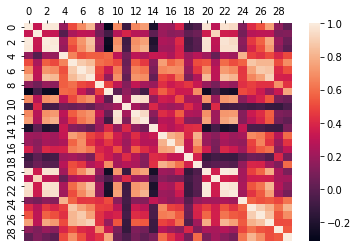

Number of components 30 Rule.No
[[ 2.18902444e-01  1.03724578e-01  2.27537293e-01  2.20994985e-01
   1.42589694e-01  2.39285354e-01  2.58400481e-01  2.60853758e-01
   1.38166959e-01  6.43633464e-02  2.05978776e-01  1.74280281e-02
   2.11325916e-01  2.02869635e-01  1.45314521e-02  1.70393451e-01
   1.53589790e-01  1.83417397e-01  4.24984216e-02  1.02568322e-01
   2.27996634e-01  1.04469325e-01  2.36639681e-01  2.24870533e-01
   1.27952561e-01  2.10095880e-01  2.28767533e-01  2.50885971e-01
   1.22904556e-01  1.31783943e-01]
 [-2.33857132e-01 -5.97060883e-02 -2.15181361e-01 -2.31076711e-01
   1.86113023e-01  1.51891610e-01  6.01653628e-02 -3.47675005e-02
   1.90348770e-01  3.66575471e-01 -1.05552152e-01  8.99796818e-02
  -8.94572342e-02 -1.52292628e-01  2.04430453e-01  2.32715896e-01
   1.97207283e-01  1.30321560e-01  1.83848000e-01  2.80092027e-01
  -2.19866379e-01 -4.54672983e-02 -1.99878428e-01 -2.19351858e-01
   1.72304352e-01  1.43593173e-01  9.79641143e-02 -8.25723507e-03
   1.4188

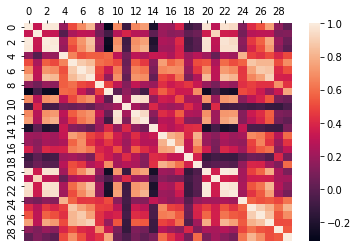

Number of components 6 Rule.Kaiser
[[ 2.18902444e-01  1.03724578e-01  2.27537293e-01  2.20994985e-01
   1.42589694e-01  2.39285354e-01  2.58400481e-01  2.60853758e-01
   1.38166959e-01  6.43633464e-02  2.05978776e-01  1.74280281e-02
   2.11325916e-01  2.02869635e-01  1.45314521e-02  1.70393451e-01
   1.53589790e-01  1.83417397e-01  4.24984216e-02  1.02568322e-01
   2.27996634e-01  1.04469325e-01  2.36639681e-01  2.24870533e-01
   1.27952561e-01  2.10095880e-01  2.28767533e-01  2.50885971e-01
   1.22904556e-01  1.31783943e-01]
 [-2.33857132e-01 -5.97060883e-02 -2.15181361e-01 -2.31076711e-01
   1.86113023e-01  1.51891610e-01  6.01653628e-02 -3.47675005e-02
   1.90348770e-01  3.66575471e-01 -1.05552152e-01  8.99796818e-02
  -8.94572342e-02 -1.52292628e-01  2.04430453e-01  2.32715896e-01
   1.97207283e-01  1.30321560e-01  1.83848000e-01  2.80092027e-01
  -2.19866379e-01 -4.54672983e-02 -1.99878428e-01 -2.19351858e-01
   1.72304352e-01  1.43593173e-01  9.79641143e-02 -8.25723507e-03
   1.4

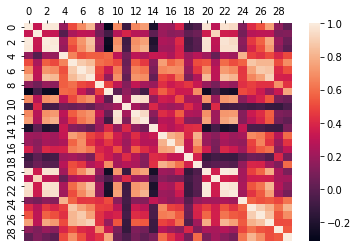

Number of components 5 Rule.BSM
[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]
 [-0.00853124  0.0645499  -0.00931422  0.02869953 -0.1042919  -0.07409157
   0.00273384 -0.02556354 -0.04023994 -0.02257409  0.26848139  0.37463367
   0.26664537  0.21600653  0.30883898  0.15477972  0.17646374  0.22465757
   0.

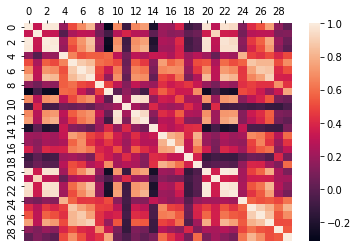

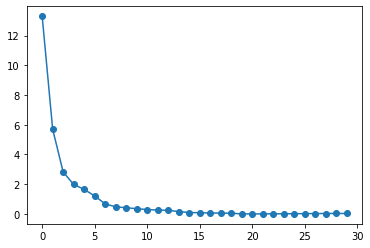

Enter number of components:
5
Number of components 5 Rule.Scree
[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]
 [-0.00853124  0.0645499  -0.00931422  0.02869953 -0.1042919  -0.07409157
   0.00273384 -0.02556354 -0.04023994 -0.02257409  0.26848139  0.37463367
   0.26664537  0.21600653  0.30883898  0.154779

In [15]:
for_all_rules(X,y)

## DIGITS DATASET - 64 vars, 10 classes

In [16]:
X, y = load_digits(return_X_y=True)
X = StandardScaler().fit_transform(X)

Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0              2              58     0.937623
1              1              57     0.855610
2              3              59     0.767945
3             13              21     0.732505
4              6              14     0.730296
5              7              15     0.711073
6             54              61     0.707519
7             33              41     0.670915
8             46              54     0.664351
9             15              23     0.658243
Наихудшая корреляция:
      FirstVariable  SecondVariable  Correlation
3711             44               3         -0.0
3712             44               2         -0.0
3713             44               1         -0.0
3714             43              43          0.0
3715             43              42          0.0
3716             43              41          0.0
3717             43              40          0.0
3718             43              38         -0.0
3719     

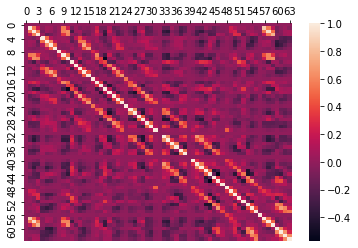

Number of components 64 Rule.No
[[ 0.          0.18223392  0.285868   ...  0.103198    0.1198106
   0.07149362]
 [ 0.         -0.04702701 -0.0595648  ...  0.24261778  0.16508926
   0.07132924]
 [ 0.          0.02358821 -0.05679875 ... -0.02227952  0.10036559
   0.09244589]
 ...
 [ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Accuracy: 0.81111
Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0              2              58     0.937623
1              1              57     0.855610
2              3              59     0.767945
3             13              21     0.732505
4              6              14     0.730296
5              7              15     0.711073
6             54              61     0.707519
7             33              41     0.670915
8             46              54     0.664351
9

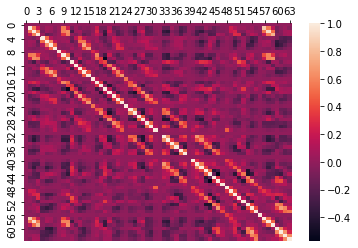

Number of components 19 Rule.Kaiser
[[ 0.          0.18223392  0.285868   ...  0.103198    0.1198106
   0.07149362]
 [ 0.         -0.04702701 -0.0595648  ...  0.24261778  0.16508926
   0.07132924]
 [ 0.          0.02358821 -0.05679875 ... -0.02227952  0.10036559
   0.09244589]
 ...
 [ 0.          0.17182076 -0.0181878  ...  0.03405311 -0.0283885
  -0.05504706]
 [ 0.          0.06572235 -0.01691111 ...  0.01927744  0.04028618
   0.0384781 ]
 [ 0.         -0.13713827 -0.02055088 ... -0.13561852 -0.07714119
   0.08593772]]
Accuracy: 0.84259
Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0              2              58     0.937623
1              1              57     0.855610
2              3              59     0.767945
3             13              21     0.732505
4              6              14     0.730296
5              7              15     0.711073
6             54              61     0.707519
7             33              41     0.670915
8             46    

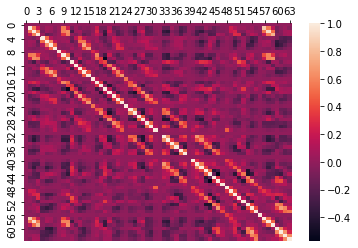

Number of components 13 Rule.BSM
[[ 0.00000000e+00  1.82233917e-01  2.85867997e-01  2.20369669e-01
  -2.51695591e-02 -9.49725041e-03 -5.24764975e-02 -6.26949928e-02
   3.47072724e-02  2.45533684e-01  2.29151737e-01 -1.07943812e-01
   3.62020917e-02  3.87115946e-02 -8.37807734e-02 -9.27750204e-02
   1.66993420e-02  1.36716497e-01 -6.30507547e-02 -1.22879267e-01
   1.48193479e-01 -2.34842464e-02 -1.71199702e-01 -1.04208373e-01
  -3.94881848e-03 -1.16389700e-01 -1.88204732e-01  6.58604010e-02
   1.43532569e-01 -1.28207049e-01 -1.80620749e-01 -5.27091667e-02
   0.00000000e+00 -2.38902514e-01 -2.35006131e-01 -5.09137360e-03
  -1.31088082e-02 -1.59116182e-01 -1.29394163e-01  0.00000000e+00
  -5.55990603e-02 -1.87157069e-01 -1.53533710e-01 -4.68257226e-02
  -1.10892715e-01 -1.07209473e-01  1.79265181e-02 -2.27270999e-03
  -2.88172859e-02  4.08680044e-02  1.10270676e-01  3.18243987e-02
  -7.90494506e-02  6.83214736e-02  1.21247066e-01  4.87711942e-02
  -1.83585908e-03  1.60395688e-01  2.798530

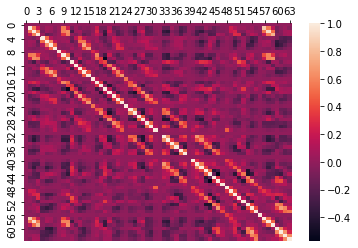

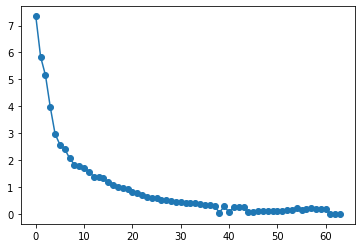

Enter number of components:
21
Number of components 21 Rule.Scree
[[ 0.          0.18223392  0.285868   ...  0.103198    0.1198106
   0.07149362]
 [ 0.         -0.04702701 -0.0595648  ...  0.24261778  0.16508926
   0.07132924]
 [ 0.          0.02358821 -0.05679875 ... -0.02227952  0.10036559
   0.09244589]
 ...
 [ 0.         -0.13713827 -0.02055088 ... -0.13561852 -0.07714119
   0.08593772]
 [ 0.          0.09828294 -0.02534165 ... -0.02090903 -0.06670758
  -0.04495687]
 [ 0.          0.00664241 -0.11715832 ... -0.05604148 -0.19709505
  -0.35101702]]
Accuracy: 0.83148


In [17]:
for_all_rules(X, y)

## NEXT DATA 